In [10]:
# Standard library imports
import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Keras and Tensorflow imports
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.regularizers import l2

In [3]:
# Image directory and csv path
image_dir = "./ISIC-images"
csv_label = pd.read_csv("class_label1.csv")
one_hot = pd.get_dummies(csv_label["category"])
data_df = pd.concat([csv_label, one_hot], axis=1)

train_df, test_df = train_test_split(data_df, random_state = 80, test_size=0.2)

In [6]:
# Parameters
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

In [4]:
# Data Generator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = image_dir,
    x_col = "name",
    y_col = ["AKIEC","BCC","BKL","DF","MEL","NV","VASC"],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = image_dir,
    x_col = "name",
    y_col = ["AKIEC","BCC","BKL","DF","MEL","NV","VASC"],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "raw"
)

Found 18956 validated image filenames.
Found 4739 validated image filenames.


In [8]:
# Define Encoder
densenet = tf.keras.applications.DenseNet169(
    include_top = False, 
    weights = "imagenet",
    input_shape = INPUT_SHAPE, 
  )

# Unfreeze the last conv block
densenet.Trainable = True
for layer in densenet.layers:
    if re.match("^conv5_block*", layer.name) is not None:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Define Network
x = GlobalAveragePooling2D()(densenet.output)
x = Dense(units = 256, activation = 'relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(units = 64, activation = 'relu')(x)
pred = Dense(units = 7, activation = 'softmax', kernel_regularizer = l2(l = 0.01))(x)

model = keras.models.Model(inputs = densenet.input, outputs = pred)
model.load_weights('cp-0016.h5')

# model.summary()

In [6]:
# Compile Model
model.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-5), # Set very low learning rate to avoid overfitting
    loss = 'categorical_crossentropy',
    metrics   = ['accuracy']
  )

In [9]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_acc',
    save_freq=2960,
    mode='auto',
    save_best_only=False)

In [10]:
# Fit model
history = model.fit(
    train_generator,
    steps_per_epoch = 592,
    epochs = 30,
    validation_data = test_generator,
    validation_steps = 148,
    callbacks=[model_checkpoint_callback]
  )

Epoch 1/30
592/592 [==============================] - 901s 2s/step - loss: 0.6787 - accuracy: 0.7859 - val_loss: 0.6117 - val_accuracy: 0.7948
Epoch 2/30
592/592 [==============================] - 864s 1s/step - loss: 0.5728 - accuracy: 0.7927 - val_loss: 0.6684 - val_accuracy: 0.7998
Epoch 3/30
592/592 [==============================] - 859s 1s/step - loss: 0.5330 - accuracy: 0.8053 - val_loss: 0.5629 - val_accuracy: 0.7958
Epoch 4/30
592/592 [==============================] - 861s 1s/step - loss: 0.5208 - accuracy: 0.8126 - val_loss: 0.5970 - val_accuracy: 0.8112
Epoch 5/30
592/592 [==============================] - 909s 2s/step - loss: 0.4990 - accuracy: 0.8167 - val_loss: 0.5425 - val_accuracy: 0.8009
Epoch 6/30
592/592 [==============================] - 866s 1s/step - loss: 0.4835 - accuracy: 0.8207 - val_loss: 0.5806 - val_accuracy: 0.7990
Epoch 7/30
592/592 [==============================] - 868s 1s/step - loss: 0.4669 - accuracy: 0.8263 - val_loss: 0.4472 - val_accuracy: 0.8353

In [11]:
model.save('./densenet_skin_finetuned.h5')

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

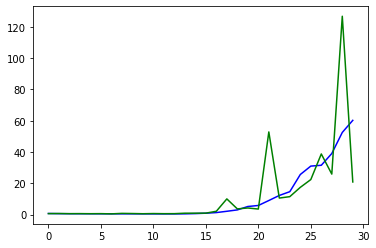

In [15]:
%matplotlib inline

epochs = range(len(loss))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and validation loss")
plt.legend()

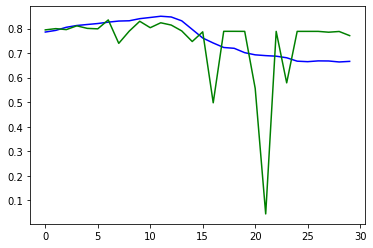

In [16]:
plt.plot(epochs, acc, "bo", label="Training loss")
plt.plot(epochs, val_acc, "b", label="validation loss")
plt.title("Training and validation accuracy")
plt.legend()